In [0]:
dbutils.fs.ls('FileStore/tables/')

[FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1709150392000),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/account-models_1/', name='account-models_1/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1706721085000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations-1.zip', name='activations-1.zip', size=8411369, modificationTime=1707257309000),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1706718502000),
 FileInfo(path='dbfs:/FileStore/tables/c

In [0]:
dbutils.fs.ls('FileStore/tables/steam_200k.csv')


[FileInfo(path='dbfs:/FileStore/tables/steam_200k.csv', name='steam_200k.csv', size=8059447, modificationTime=1714306157000)]

In [0]:
dbutils.fs.ls('FileStore/tables/games.csv')


[FileInfo(path='dbfs:/FileStore/tables/games.csv', name='games.csv', size=143639, modificationTime=1712594410000)]

Loading Necessary Libraries

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit

import mlflow
from pyspark.ml.recommendation import ALS

mlflow.pyspark.ml.autolog()

Loading Datasets

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

schema = StructType([
    StructField('Member_id', IntegerType()),
    StructField('NameOfGames', StringType()),
    StructField('behaviour', StringType()),
    StructField('Hours_Played', DoubleType())
])

steam = spark.read.csv('/FileStore/tables/steam_200k.csv', schema=schema, header=False)

In [0]:
display(steam.limit(5))

Member_id,NameOfGames,behaviour,Hours_Played
151603712,The Elder Scrolls V Skyrim,purchase,1.0
151603712,The Elder Scrolls V Skyrim,play,273.0
151603712,Fallout 4,purchase,1.0
151603712,Fallout 4,play,87.0
151603712,Spore,purchase,1.0


In [0]:
gamesSchema = StructType([
    StructField('GameId', IntegerType()),
    StructField('GameName', StringType())
])
games = spark.read.csv('dbfs:/FileStore/tables/games.csv', 
                       header=False,
                       schema= gamesSchema)
display(games.limit(5))

GameId,GameName
1,The Elder Scrolls V Skyrim
2,Fallout 4
3,Spore
4,Fallout New Vegas
5,Left 4 Dead 2


CHECKING FOR NULL VALUES

In [0]:
# Count the number of null values in each column before dropping
null_count_steam = steam.select([count(when(isnull(c), c)).alias(c) for c in steam.columns])
null_count_games = games.select([count(when(isnull(c), c)).alias(c) for c in games.columns])

# Print the null counts 
print("Steam Null counts:")
null_count_steam.display()
print("\nGames Null counts:")
null_count_games.display()

Steam Null counts:


Member_id,NameOfGames,behaviour,Hours_Played
0,0,0,0



Games Null counts:


GameId,GameName
0,0


EXPLORATORY ANALYSIS

In [0]:
#Total Count of Files
games_count= games.count()
steam_count= steam.count()

print(f'Length of the Files \n\n Games: {games_count} \n\n Steam: {steam_count}')

Length of the Files 

 Games: 5155 

 Steam: 200000


In [0]:
#Distinct number of games available on Steam
distinct_games_count= steam.select('NameOfGames').distinct().count()
print(f'The Distinct Number of Games Played on Steam file: {distinct_games_count}')

The Distinct Number of Games Played on Steam file: 5155


In [0]:
# Check for duplicates in the dataset
duplicates = steam.groupBy(steam.columns).count().filter(col("count") > 1)

# Display duplicates
if duplicates.count() > 0:
    print("Duplicates found:")
    display(duplicates.limit(5))
else:
    print("No duplicates found.")

Duplicates found:


Member_id,NameOfGames,behaviour,Hours_Played,count
9823354,Sid Meier's Civilization IV Warlords,purchase,1.0,2
2259650,Sid Meier's Civilization IV Colonization,purchase,1.0,2
56038151,Grand Theft Auto San Andreas,purchase,1.0,2
142001340,Grand Theft Auto San Andreas,purchase,1.0,2
152959594,Grand Theft Auto III,purchase,1.0,2


In [0]:
# Remove duplicates
steam = steam.dropDuplicates()

behaviour,count,Percentage
purchase,128804,64.63
play,70489,35.37


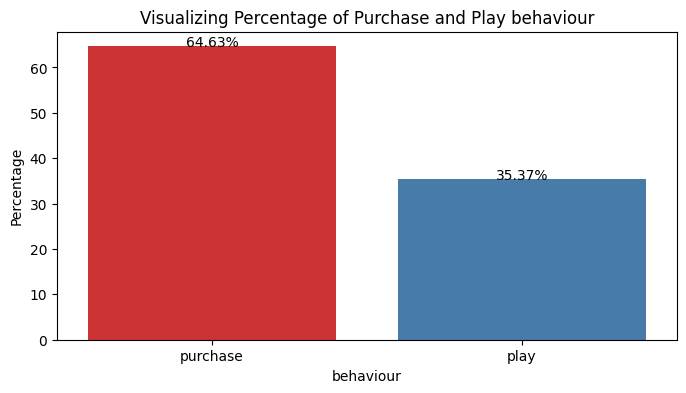

In [0]:
#Calculate the percentage of game purchases compared to played games
total_records = steam.count()

#Group the data by behaviour (purchase or play), count occurrences, and calculate the percentage
purchase_play_percentage = steam.groupBy("behaviour") \
.count() \
.withColumn("Percentage", round((col("count") / lit(total_records)) * 100, 2))

#Display the results
purchase_play_percentage.display()

#Convert the Spark DataFrame to a Pandas DataFrame for visualization
purchase_play_percentage_pd = purchase_play_percentage.toPandas()

#Plotting the percentage of purchase and play behaviour
plt.figure(figsize=(8, 4))
sns.barplot(x='behaviour', y='Percentage', data=purchase_play_percentage_pd, palette='Set1')

#Annotate each bar with its percentage value
for index, row in purchase_play_percentage_pd.iterrows():
    plt.text(row.name, row.Percentage, f'{row.Percentage}%', color='black', ha="center")

#Set plot title and labels
plt.title('Visualizing Percentage of Purchase and Play behaviour')
plt.xlabel('behaviour')
plt.ylabel('Percentage')

#Show the plot
plt.show()

NameOfGames,count
Dota 2,4841
Team Fortress 2,2323
Unturned,1563
Counter-Strike Global Offensive,1412
Half-Life 2 Lost Coast,981
Counter-Strike Source,978


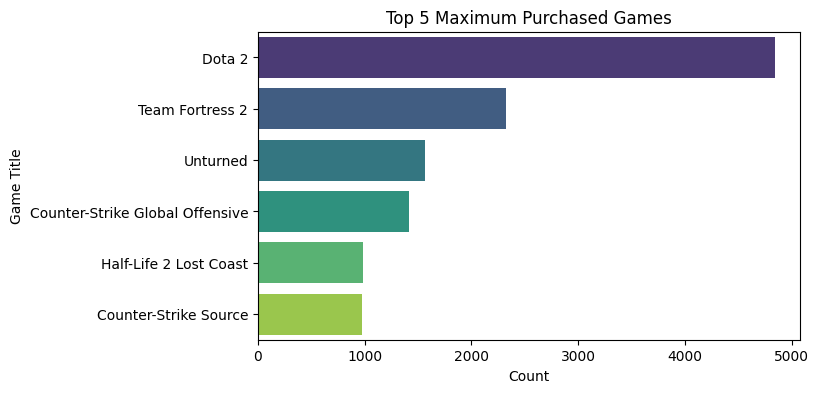

In [0]:
#Most Purchased Steam games by users
purchase_games = steam.filter(col('behaviour') == 'purchase')
top_purchase_games = purchase_games.groupBy('NameOfGames').count()
top_purchase_games = top_purchase_games.orderBy('count', ascending=False).limit(6)
top_purchase_games.display()

#Convert to Pandas DataFrame
top_purchase_games = top_purchase_games.toPandas()

# Plot the countplot using Seaborn
plt.figure(figsize=(7, 4))
sns.barplot(x='count', y='NameOfGames', data=top_purchase_games, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Game Title')
plt.title('Top 5 Maximum Purchased Games')
plt.xticks(rotation = 0)
plt.show()

NameOfGames,sum(Hours_Played)
Dota 2,981684.6000000001
Counter-Strike Global Offensive,322771.60000000015
Team Fortress 2,173673.3
Counter-Strike,134261.09999999992
Sid Meier's Civilization V,99821.29999999999


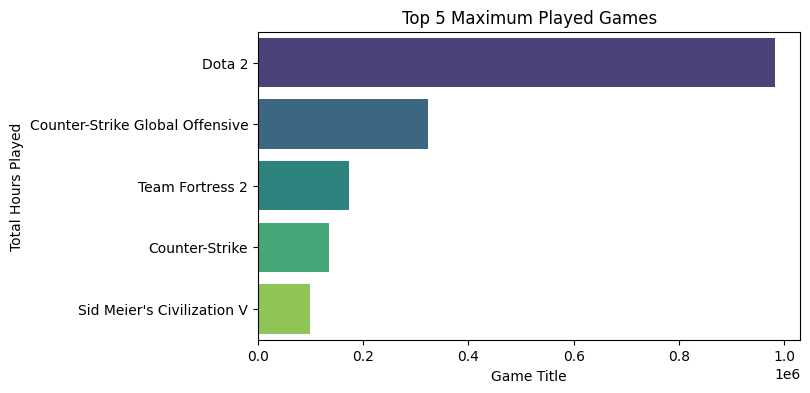

In [0]:
# Top 5 Maximum Played Games
top_played_games = steam.filter(steam['behaviour'] == 'play') \
                            .groupBy('NameOfGames') \
                            .sum('Hours_Played') \
                            .orderBy('sum(Hours_Played)', ascending=False) \
                            .limit(5)
 

top_played_games_pandas = top_played_games.toPandas()
top_played_games_pandas.display()

plt.figure(figsize=(7, 4))
sns.barplot(x='sum(Hours_Played)', y='NameOfGames', data= top_played_games_pandas, palette='viridis')
plt.xlabel('Game Title')
plt.ylabel('Total Hours Played')
plt.title('Top 5 Maximum Played Games')
plt.xticks(rotation=0)
plt.show()

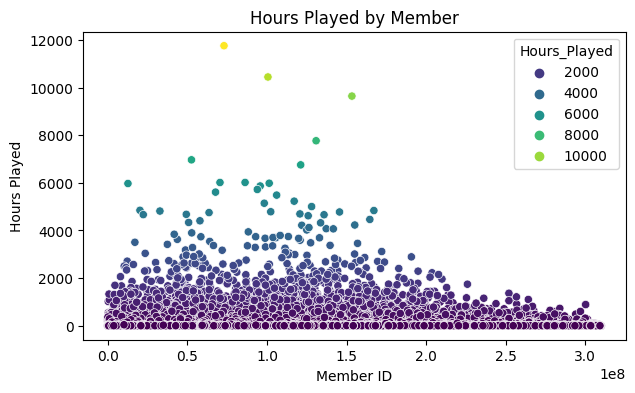

In [0]:
# Plot the scatter plot
plt.figure(figsize=(7, 4))
sns.scatterplot(x='Member_id', y='Hours_Played', data=steam.toPandas(), hue= 'Hours_Played', palette= 'viridis')

# Set plot title and labels
plt.title('Hours Played by Member')
plt.xlabel('Member ID')
plt.ylabel('Hours Played')

# Show plot
plt.show()

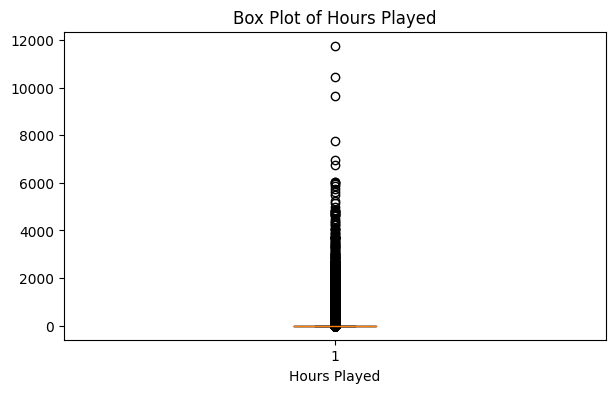

In [0]:
#check for outliers on the hours played samples provided
plt.figure(figsize=(7, 4))
plt.boxplot(data=steam.toPandas(), x='Hours_Played')

plt.xlabel('Hours Played')
plt.title('Box Plot of Hours Played')

plt.show()

MODEL CREATION AND EVALUATION

Creation of Distinct/Unique Steam Game IDs

In [0]:
# Create a StringIndexer to assign unique numerical identifiers to each game based on frequency of occurrence
indexer = StringIndexer(inputCol='NameOfGames', outputCol='Game_Id', stringOrderType='frequencyDesc')

# Fit the StringIndexer model to the 'steam' DataFrame and transform the data to generate game IDs
steam_2 = indexer.fit(steam).transform(steam)

# Increment all Game IDs by one to avoid starting from zero and ensure uniqueness
steam_2 = steam_2.withColumn('Game_Id', steam_2['Game_Id'] + 1)

2024/07/19 09:52:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd508005f8e7c4dacb4df5ac31f7e5665', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


In [0]:
game_identifier_generated = steam_2.select('Game_Id', 'NameOfGames').dropDuplicates()

In [0]:
display(game_identifier_generated.orderBy('Game_ID').limit(5))

Game_Id,NameOfGames
1.0,Dota 2
2.0,Team Fortress 2
3.0,Counter-Strike Global Offensive
4.0,Unturned
5.0,Left 4 Dead 2


Sorting Games by Played and Purchased and Eliminating Unwanted Training Columns

In [0]:
# Separate Purchased and Played Games
# Filter the DataFrame to select rows where 'behaviour' is 'purchase'
purchased_games = steam_2.filter(col('behaviour') == 'purchase')

# Filter the DataFrame to select rows where 'behaviour' is 'play'
played_games = steam_2.filter(col('behaviour') == 'play')

In [0]:
# Remove Unnecessary Columns and Adjust Data Types for Purchased Games
purchased_games = purchased_games.drop('NameOfGames', 'behaviour', 'GameName')
purchased_games = purchased_games.withColumn('Hours_Played', col('Hours_Played').cast(IntegerType()))

# Remove Unnecessary Columns and Adjust Data Types for Played Games
played_games = played_games.drop('NameOfGames', 'behaviour', 'GameName')
played_games = played_games.withColumn('Hours_Played', col('Hours_Played').cast(FloatType())).dropna()

# Display the DataFrame for Played Games
display(played_games.limit(5))

# Display the DataFrame for Purchased Games
display(purchased_games.limit(5))

Member_id,Hours_Played,Game_Id
53875128,9.8,731.0
53875128,0.1,604.0
65117175,3.3,97.0
11373749,7.0,1926.0
11373749,2.3,148.0


Member_id,Hours_Played,Game_Id
53875128,1,602.0
53875128,1,4082.0
126340495,1,81.0
97298878,1,560.0
226212066,1,1452.0


Tackling Outliers

In [0]:
# Calculate Quantiles and Interquartile Range (IQR) for Played Games
quantiles = played_games.approxQuantile('Hours_Played', [0.25, 0.75], 0.05)

# Extract Q1 and Q3 from the quantiles
q1 = quantiles[0]
q3 = quantiles[1]

# Calculate the Interquartile Range (IQR)
iqr = q3 - q1

# Define lower and upper bounds for outlier detection
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

# Filter out rows outside the lower and upper bounds to remove outliers
played_games = played_games.filter((col('Hours_Played') >= lower_bound) & (col('Hours_Played') <= upper_bound))

# Display the cleaned DataFrame for Played Games
played_games.show()

+---------+------------+-------+
|Member_id|Hours_Played|Game_Id|
+---------+------------+-------+
| 53875128|         9.8|  731.0|
| 53875128|         0.1|  604.0|
| 65117175|         3.3|   97.0|
| 11373749|         7.0| 1926.0|
| 11373749|         2.3|  148.0|
| 56038151|         2.8|  112.0|
|100519466|         1.6|   21.0|
|210669058|         1.4|    1.0|
|229467150|        24.0|    1.0|
|111316830|         6.0| 3220.0|
| 72842694|         1.7|  971.0|
| 65229865|        22.0| 1342.0|
| 65958466|         7.1|  454.0|
| 68224834|         4.8|    9.0|
| 34177747|         0.3|  562.0|
|196223620|        23.0|   94.0|
|149438233|         0.2|    2.0|
|118894547|         0.6|  274.0|
| 87071236|         1.7|  372.0|
|182399789|         0.2|  191.0|
+---------+------------+-------+
only showing top 20 rows



TRAINING RECOMMENDATION MODELS

In [0]:
# Splitting the Data
(training, test) = played_games.randomSplit([0.8, 0.2], seed=43)

In [0]:
# Training the Model
als = ALS(maxIter= 11, regParam=0.03, userCol='Member_id', itemCol='Game_Id', ratingCol='Hours_Played')
model= als.fit(training)

2024/07/19 09:52:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9ecf0416ae1c4418b4ed6f291f1d89ed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/07/19 09:52:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

In [0]:
# Generate Predictions on Test Dataset
# Apply the collaborative filtering model to generate predictions on the test dataset and drop rows with missing values
predictions = model.transform(test).dropna()

# Display the DataFrame containing predictions
display(predictions.limit(5))

Member_id,Hours_Played,Game_Id,prediction
5250,0.8,2,0.8626865
86540,3.6,65,3.5660095
229911,0.2,24,0.17407441
298950,0.3,2049,0.44893885
298950,0.6,211,3.0767598


In [0]:
# Evaluate Predictions
# Initialize a RegressionEvaluator to calculate the Root Mean Square Error (RMSE) between actual and predicted values
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")

# Calculate the RMSE by comparing actual and predicted values in the 'predictions' DataFrame
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print("Root Mean Square Error: ", rmse)

Root Mean Square Error:  6.321007378965163


Make a Purchase Recommendation for the User who has the Fewest Games Purchased and the Highest Gaming Hours.

In [0]:
#using Sql for further information
steam_hours = steam.filter(col('Behaviour')== 'play')
steam_hours.createOrReplaceTempView('Steam')

In [0]:
%sql

-- Identify Users with Potential for More Purchases
SELECT Member_id, COUNT(Member_id) AS count, SUM(Hours_Played) AS SumOfHoursPlayed
FROM steam
GROUP BY Member_id
HAVING (COUNT(Member_id) BETWEEN 7 AND 15) AND (SUM(Hours_Played) > 4000)
ORDER BY count ASC

Member_id,count,SumOfHoursPlayed
121900241,7,5038.799999999999
42935819,7,8172.9
78799565,8,5186.9
137222368,9,4246.8
20207081,9,5316.4
42849279,9,6766.2
64392327,10,5301.0
49380630,11,5525.9
57905818,13,5534.8
40080833,13,4057.9


In [0]:
# Generate Recommendations for All Users
userRec = model.recommendForAllUsers(10)

In [0]:
#show the recommendations for users.
display(userRec.limit(5))

Member_id,recommendations
76767,"List(List(239, 110.49102), List(568, 103.405334), List(598, 102.04291), List(812, 100.71967), List(297, 96.87427), List(273, 94.903465), List(626, 91.64597), List(1235, 90.56896), List(2627, 88.56584), List(1129, 86.881805))"
144736,"List(List(1041, 0.30621102), List(566, 0.2507793), List(260, 0.24544285), List(1096, 0.22208089), List(1102, 0.2151988), List(1176, 0.21334592), List(605, 0.20939925), List(660, 0.20883104), List(1980, 0.20592958), List(806, 0.20555407))"
229911,"List(List(235, 26.692364), List(1980, 25.068565), List(682, 22.32917), List(1545, 21.486996), List(3188, 20.853466), List(465, 20.811626), List(1192, 20.537746), List(3898, 19.684948), List(1539, 19.354696), List(1999, 18.957535))"
948368,"List(List(1041, 19.2028), List(566, 12.896865), List(712, 12.672724), List(806, 12.245248), List(260, 12.156933), List(605, 11.596186), List(531, 11.481076), List(118, 11.441738), List(539, 11.306769), List(298, 10.935608))"
975449,"List(List(328, 54.27542), List(509, 53.138332), List(256, 45.078007), List(1163, 45.04588), List(751, 42.222713), List(1608, 41.53339), List(1102, 41.38118), List(537, 40.171417), List(344, 39.152245), List(899, 39.10846))"


In [0]:
# Display Recommendations for a Specific User
userRec.where(userRec.Member_id == 121900241)\
    .select("recommendations")\
    .withColumn("recommendations", explode("recommendations"))\
    .select("recommendations.Game_Id", "recommendations.rating")\
    .join(game_identifier_generated, ["Game_ID"])\
    .show(truncate= False)

+-------+--------+-----------------------+
|Game_Id|rating  |NameOfGames            |
+-------+--------+-----------------------+
|1163   |99.23217|Rayman Legends         |
|1997   |84.94057|Rampage Knights        |
|1608   |72.3486 |Street Fighter IV      |
|255    |71.66237|Football Manager 2012  |
|619    |71.17752|Football Manager 2011  |
|3898   |68.49272|Comanche 4             |
|572    |68.47299|Supreme Commander      |
|4454   |67.98691|Warrior Kings Battles  |
|733    |67.55054|X-COM UFO Defense      |
|2181   |65.08819|Space Empires IV Deluxe|
+-------+--------+-----------------------+



In [0]:
%sql

-- Compare Recommended Games with User's Past Play History
select *
from steam
where member_id = '121900241' 

Member_id,NameOfGames,behaviour,Hours_Played
121900241,Left 4 Dead 2,play,33.0
121900241,BattleBlock Theater,play,0.9
121900241,Counter-Strike Global Offensive,play,785.0
121900241,Counter-Strike,play,4217.0
121900241,Counter-Strike Nexon Zombies,play,0.4
121900241,Half-Life 2,play,2.3
121900241,Counter-Strike Condition Zero,play,0.2


Hyper Parameter Tuning

In [0]:
# Define the ALS model with parameters
als = ALS(maxIter=5, userCol="Member_id", itemCol="Game_Id", ratingCol="Hours_Played", coldStartStrategy="drop", seed=43)

# Create a parameter grid using ParamGridBuilder
parameters = ParamGridBuilder()\
.addGrid(als.rank, [9, 12, 15])\
.addGrid(als.regParam, [0.03, 0.07, 0.1, 0.16, 0.2, 0.3])\
.build()

In [0]:
# Define TrainValidationSplit for model evaluation
tvs = TrainValidationSplit()\
.setSeed(43)\
.setTrainRatio(0.75)\
.setEstimatorParamMaps(parameters)\
.setEstimator(als)\
.setEvaluator(evaluator)

In [0]:
# Train the model using grid search with TrainValidationSplit
grid_search_play_model = tvs.fit(training)

2024/07/19 10:05:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd10437da3e55439ba12aeedc980e81d2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/07/19 10:30:54 WARNING mlflow.pyspark.ml: Model TrainValidationSplitModel_3d010732e8b9 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


In [0]:
# Select the best model and identify its parameters
best_model = grid_search_play_model.bestModel

# Print the parameters for the best model
print("Parameters for the best model:")
print(f"Rank Parameter: {best_model.rank}")
print(f"RegParam Parameter: {best_model._java_obj.parent().getRegParam()}")

Parameters for the best model:
Rank Parameter: 15
RegParam Parameter: 0.3


In [0]:
# Evaluate the best model on the test data
evaluation_result = evaluator.evaluate(best_model.transform(test))
print(f"The rsme is: ", evaluation_result)

The rsme is:  4.714960802013757


Make Purchase Recommendation for Users

In [0]:
# Split Data for Purchased Games into Training and Testing Sets
# Randomly split the purchased_games DataFrame into training (80%) and testing (20%) sets
(purchase_training, purchase_test) = purchased_games.randomSplit([0.8, 0.2], seed=43)

In [0]:
# Define and Train ALS Model for Purchased Games
# Define ALS model with specified parameters for collaborative filtering on purchased games
Purchase_als = ALS(maxIter=10, regParam=0.05, userCol='Member_id', itemCol='Game_Id', ratingCol='Hours_Played')

# Train ALS model on the training data for purchased games
Purchase_model = Purchase_als.fit(purchase_training)

2024/07/19 10:31:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ab07066a16a54cbb96132bf4d8821305', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/07/19 10:31:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

In [0]:
# make prediction on test Dataset
Purchase_predictions = model.transform(purchase_test).dropna()
display(Purchase_predictions.limit(5))

Member_id,Hours_Played,Game_Id,prediction
5250,1,7,-0.9806007
76767,1,211,23.23826
86540,1,5,15.585196
86540,1,847,-0.75120294
86540,1,1391,-1.2856212


In [0]:
#Evaluate the predictions
Purchase_predictions = Purchase_model.transform(purchase_test).dropna()

Purchase_evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")

rmse = Purchase_evaluator.evaluate(Purchase_predictions)

print("Root Mean Square Error: ", rmse)

Root Mean Square Error:  0.05201548746170184


Recommend Games to Purchase for Users

In [0]:
#Recommend games for a user
Purchase_recommendation= Purchase_model.recommendForAllUsers(10)

In [0]:
Purchase_recommendation.where(Purchase_recommendation.Member_id == 121900241)\
    .select("recommendations")\
    .withColumn("recommendations", explode("recommendations"))\
    .select("recommendations.Game_Id", "recommendations.rating")\
    .join(game_identifier_generated, ["Game_ID"])\
    .show(truncate= False)

+-------+----------+----------------------------------+
|Game_Id|rating    |NameOfGames                       |
+-------+----------+----------------------------------+
|3596   |0.9578545 |Pro Cycling Manager Season 2009   |
|2006   |0.9558228 |Star Trek D-A-C                   |
|2752   |0.9558252 |Pro Evolution Soccer 2016         |
|1488   |0.961683  |GEARCRACK Arena                   |
|3339   |0.9611796 |Warhammer Online Age of Reckoning |
|1350   |0.9559019 |Pro Evolution Soccer 2015         |
|1453   |0.96214527|NBA 2K9                           |
|2575   |0.9562943 |Shadow Harvest Phantom Ops        |
|3510   |0.9579508 |Good Ol Times                     |
|3375   |0.96069044|Age of Conan Rise of the Godslayer|
+-------+----------+----------------------------------+

